## PeakData - Data science hiring

##### Your task is to create an algorithm, that takes html page as input and infers if the page contains the information about cancer tumorbaord or not.
##### What is a tumor board? Tumor Board is a consilium of doctors (usually from diferent disciplines) discussing cancer cases in their deprtments.

### Import libraries

In [375]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import unicodedata
import re
import os

import nltk
import string
from nltk.corpus import stopwords
nltk.download("stopwords")

from google_trans_new import google_translator

from langid.langid import LanguageIdentifier, model

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\onlyt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [723]:
def get_text(find_list):
    return '. '.join([item.get_text() for item in find_list])
    

def get_article(soup):
    header = None
    body = None
    meta_description = None
    meta_keywords = None
    
    try:
        header = get_text(soup.find_all('title'))
    except:
        try:
            header = get_text(soup.find_all(re.compile('h\d')))
        except:
            pass
    
    try:
        meta_description = soup.find_all('meta', {'name': 'description'})[0]['content']
    except:
        pass
    
    try:
        meta_keywords = soup.find_all('meta', {'name': 'keywords'})[0]['content']
    except:
        pass
    
    body = soup.get_text(' ')
    
    return [header, meta_description, meta_keywords, body]

def clean_text(text):
    if text == None:
        return None
    text = text.lower()
    text = " ".join([word for word in text.split()])
    
    #Remove mentions
    text = re.sub("@\S+", "", text)
    #Remove urls
    text = re.sub("https?:\/\/.*[\r\n]*", "", text)
    #Remove hashtags
    text = re.sub("#", "", text)
    #Remove punctuations
    punct = set(string.punctuation) 
    text = "".join([ch for ch in text if ch not in punct])
    #Remove numbers
    text = " ".join([re.sub(r'[0-9]+', '', word) for word in text.split()])
    
    return text.strip()

In [722]:
%%time

articles = []

for file in os.listdir('htmls'):
    with open(f'htmls/{file}', 'rt', encoding = "ISO-8859-1") as html_file:
        text = html_file.read()
        text = BeautifulSoup(text, 'html.parser')
    articles.append([int(file.split('.')[0])]+get_article(text))
    
df = pd.DataFrame(articles, columns = ['doc_id', 'Title', 'Meta description', 'Meta Keywords', 'Body'])

Wall time: 11.3 s


In [724]:
df.head()

doc_id                                              Title  \
0       0  BauchspeicheldrÃ¼se | Klinik fÃ¼r Allgemein-, ...   
1       1      Elbe-Elster Klinikum - Chirurgie Finsterwalde   
2      10  Presse und Auszeichnungen - krebszentrum.kreis...   
3     100                           Ãrztliche Weiterbildung   
4     101               Krankenhaus Buchholz - Weiterbildung   

                                    Meta description  \
0                                               None   
1  Elbe-Elster Klinikum GmbH, Standorte: Elsterwe...   
2                                                      
3                                               None   
4  Das Krankenhaus Buchholz liegt landschaftlich ...   

                                       Meta Keywords  \
0                                               None   
1  'Elbe-Elster Klinikum',Klinikum,'Grundversorgu...   
2                                                      
3                                               None   
4                               Krankenhaus Buchholz   

                                                Body  
0  \n \n \n \n \n \n \n BauchspeicheldrÃ¼se | Kli...  
1  \n \n \n \n \n \n \n \n Elbe-Elster Klinikum -...  
2  \n \n \n \n Presse und Auszeichnungen - krebsz...  
3  \n \n \n \n \n \n Ãrztliche Weiterbildung \n ...  
4  \n \n \n \n \n \n \n \n \n \n \n \n \n \n Kran...

### Articles cleaning

In [725]:
%%time

df['Title'] = df['Title'].apply(clean_text)
df['Meta description'] = df['Meta description'].apply(clean_text)
df['Meta Keywords'] = df['Meta Keywords'].apply(clean_text)
df['Body'] = df['Body'].apply(clean_text)

Wall time: 651 ms


In [726]:
df.head()

doc_id                                              Title  \
0       0  bauchspeicheldrã¼se klinik fã¼r allgemein visz...   
1       1         elbeelster klinikum chirurgie finsterwalde   
2      10  presse und auszeichnungen krebszentrumkreiskli...   
3     100                           ãrztliche weiterbildung   
4     101                 krankenhaus buchholz weiterbildung   

                                    Meta description  \
0                                               None   
1  elbeelster klinikum gmbh standorte elsterwerda...   
2                                                      
3                                               None   
4  das krankenhaus buchholz liegt landschaftlich ...   

                                       Meta Keywords  \
0                                               None   
1  elbeelster klinikumklinikumgrundversorgung im ...   
2                                                      
3                                               None   
4                               krankenhaus buchholz   

                                                Body  
0  bauchspeicheldrã¼se klinik fã¼r allgemein visz...  
1  elbeelster klinikum chirurgie finsterwalde suc...  
2  presse und auszeichnungen krebszentrumkreiskli...  
3  ãrztliche weiterbildung impressum datenschutz...  
4  krankenhaus buchholz weiterbildung krankenhaus...

### Detect languages and translation

In [727]:
%%time

lang_identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

df['lang'] = df['Body'].apply(lambda x: lang_identifier.classify(x)[0])

Wall time: 5.75 s


In [728]:
df.lang.value_counts()

de    145
en      3
Name: lang, dtype: int64

In [729]:
df[df.lang != 'de']

doc_id                                              Title  \
21     117  publications nct nationales centrum fã¼r tumor...   
23     119  nct mol diax nct nationales centrum fã¼r tumor...   
32     127  vendor neutral archiving solutions vna siemens...   

                                     Meta description  \
21  das nationale centrum fã¼r tumorerkrankungen n...   
23  das nationale centrum fã¼r tumorerkrankungen n...   
32  optimize your organizations data flow with sie...   

                                        Meta Keywords  \
21                                               None   
23                                               None   
32  vna healthcare data management vendor neutral ...   

                                                 Body lang  
21  publications nct nationales centrum fã¼r tumor...   en  
23  nct mol diax nct nationales centrum fã¼r tumor...   en  
32  vendor neutral archiving solutions vna siemens...   en

In [730]:
%%time

translator = google_translator()

for index, row in df.iterrows():
    if row['lang'] != 'de':
        df.loc[index, 'Body'] = translator.translate(row['Body'][:4999], lang_src=row['lang'], lang_tgt='de')
        if row['Title'] != None:
            df.loc[index, 'Title'] = translator.translate(row['Title'][:4999], lang_src=row['lang'], lang_tgt='de')
        if row['Meta description'] != None:
            df.loc[index, 'Meta description'] = translator.translate(row['Meta description'][:4999], lang_src=row['lang'], lang_tgt='de')
        if row['Meta Keywords'] != None:
            df.loc[index, 'Meta Keywords'] = translator.translate(row['Meta Keywords'][:4999], lang_src=row['lang'], lang_tgt='de')

Wall time: 2.48 s


In [731]:
df[df.lang != 'de']

doc_id                                              Title  \
21     117  Publikationen NCT NATIONEN CENTRUM FÜR TUMORKR...   
23     119  NCT MOL DIAX NCT NATIONEN CENTRUM FÜR TUMORKRA...   
32     127  Anbieter-neutrale Archivierungslösungen VNA Si...   

                                     Meta description  \
21  Das Nationale Centrum Für Tumorerkrankungen NC...   
23  Das Nationale Centrum Für Tumorerkrankungen NC...   
32  Optimieren Sie Ihren Organisationen Data Flow ...   

                                        Meta Keywords  \
21                                               None   
23                                               None   
32  VNA Healthcare Data Management Anbieter Neutra...   

                                                 Body lang  
21  Publikationen NCT NATATORES CENTRUM FÜR TUMORK...   en  
23  NCT MOL DIAX NCT NATIONEN CENTRUM FÜR TUMORKRA...   en  
32  herstellerneutrale Archivierungslösungen vna s...   en

In [732]:
df = df.fillna('')
df['Full text'] = df['Title'] + ' ' + df['Meta description'] + ' ' + df['Meta Keywords'] + ' ' + df['Body']

### Remove stopwords

In [733]:
%%time

stop_words = set(stopwords.words("german"))

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

df['Full text'] = df['Full text'].apply(remove_stopwords)

Wall time: 108 ms


In [734]:
df.head()

doc_id                                              Title  \
0       0  bauchspeicheldrã¼se klinik fã¼r allgemein visz...   
1       1         elbeelster klinikum chirurgie finsterwalde   
2      10  presse und auszeichnungen krebszentrumkreiskli...   
3     100                           ãrztliche weiterbildung   
4     101                 krankenhaus buchholz weiterbildung   

                                    Meta description  \
0                                                      
1  elbeelster klinikum gmbh standorte elsterwerda...   
2                                                      
3                                                      
4  das krankenhaus buchholz liegt landschaftlich ...   

                                       Meta Keywords  \
0                                                      
1  elbeelster klinikumklinikumgrundversorgung im ...   
2                                                      
3                                                      
4                               krankenhaus buchholz   

                                                Body lang  \
0  bauchspeicheldrã¼se klinik fã¼r allgemein visz...   de   
1  elbeelster klinikum chirurgie finsterwalde suc...   de   
2  presse und auszeichnungen krebszentrumkreiskli...   de   
3  ãrztliche weiterbildung impressum datenschutz...   de   
4  krankenhaus buchholz weiterbildung krankenhaus...   de   

                                           Full text  
0  bauchspeicheldrã¼se klinik fã¼r allgemein visz...  
1  elbeelster klinikum chirurgie finsterwalde elb...  
2  presse auszeichnungen krebszentrumkreisklinike...  
3  ãrztliche weiterbildung ãrztliche weiterbild...  
4  krankenhaus buchholz weiterbildung krankenhaus...

### Number of words in each article

In [735]:
df['Body_words'] = df['Full text'].apply(lambda x: len(x.split()))
df['Mean word len'] = df['Full text'].apply(lambda x: np.mean([len(word) for word in x.split()]))
df['tumorbaord'] = df['Full text'].apply(lambda x: 1 if 'tumorboard' in x else 0)
df['N_tumorbaord'] = df['Full text'].apply(lambda x: x.count('tumorboard'))

In [736]:
df.describe()

doc_id    Body_words  Mean word len  tumorbaord  N_tumorbaord
count  148.000000    148.000000     148.000000  148.000000    148.000000
mean    73.500000   1054.750000       9.853892    0.277027      0.479730
std     42.868014   1540.295801       0.731350    0.449050      1.026649
min      0.000000     74.000000       6.259759    0.000000      0.000000
25%     36.750000    475.000000       9.460566    0.000000      0.000000
50%     73.500000    667.500000       9.914749    0.000000      0.000000
75%    110.250000   1237.500000      10.273507    1.000000      1.000000
max    147.000000  17186.000000      11.402340    1.000000      8.000000

### Load train data

In [737]:
train = pd.read_csv('train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     100 non-null    object
 1   doc_id  100 non-null    int64 
 2   label   100 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


In [738]:
train.head()

url  doc_id  label
0  http://elbe-elster-klinikum.de/fachbereiche/ch...       1      1
1  http://klinikum-bayreuth.de/einrichtungen/zent...       3      3
2  http://klinikum-braunschweig.de/info.php/?id_o...       4      1
3  http://klinikum-braunschweig.de/info.php/?id_o...       5      1
4  http://klinikum-braunschweig.de/zuweiser/tumor...       6      3

### Merge articles with labels

In [739]:
train = pd.merge(train, df, on = 'doc_id')
train.shape

(100, 13)

In [740]:
train.head()

url  doc_id  label  \
0  http://elbe-elster-klinikum.de/fachbereiche/ch...       1      1   
1  http://klinikum-bayreuth.de/einrichtungen/zent...       3      3   
2  http://klinikum-braunschweig.de/info.php/?id_o...       4      1   
3  http://klinikum-braunschweig.de/info.php/?id_o...       5      1   
4  http://klinikum-braunschweig.de/zuweiser/tumor...       6      3   

                                               Title  \
0         elbeelster klinikum chirurgie finsterwalde   
1            onkologisches zentrum klinikum bayreuth   
2  zentrum sozialpã¤diatrisches zentrum stã¤dtisc...   
3  leistung spezielle unterstã¼tzung bei der anme...   
4  zuweiser tumorkonferenzen tumorkonferenz gastr...   

                                    Meta description  \
0  elbeelster klinikum gmbh standorte elsterwerda...   
1                                                      
2                                                      
3                                                      
4                                                      

                                       Meta Keywords  \
0  elbeelster klinikumklinikumgrundversorgung im ...   
1  onkologisches zentrum brustzentrum darmzentrum...   
2                                                      
3                                                      
4                                                      

                                                Body lang  \
0  elbeelster klinikum chirurgie finsterwalde suc...   de   
1  onkologisches zentrum klinikum bayreuth aktuel...   de   
2  zentrum sozialpã¤diatrisches zentrum stã¤dtisc...   de   
3  leistung spezielle unterstã¼tzung bei der anme...   de   
4  zuweiser tumorkonferenzen tumorkonferenz gastr...   de   

                                           Full text  Body_words  \
0  elbeelster klinikum chirurgie finsterwalde elb...         693   
1  onkologisches zentrum klinikum bayreuth onkolo...        2039   
2  zentrum sozialpã¤diatrisches zentrum stã¤dtisc...         761   
3  leistung spezielle unterstã¼tzung anmeldung ge...         354   
4  zuweiser tumorkonferenzen tumorkonferenz gastr...         398   

   Mean word len  tumorbaord  N_tumorbaord  
0      10.688312           1             1  
1       9.289848           0             0  
2       9.722733           0             0  
3       9.838983           0             0  
4       9.638191           0             0

<AxesSubplot:title={'center':'Number of articles in classes'}>

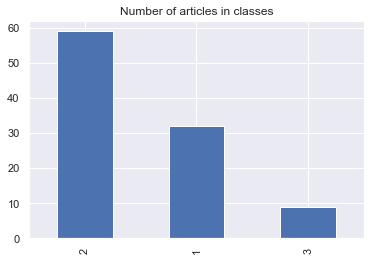

In [741]:
plt.title('Number of articles in classes')
train.label.value_counts().plot(kind='bar')

### From above plot we can see that we have unbalanced dataset.

#### Let's check KDE plot for number of words in articles by label

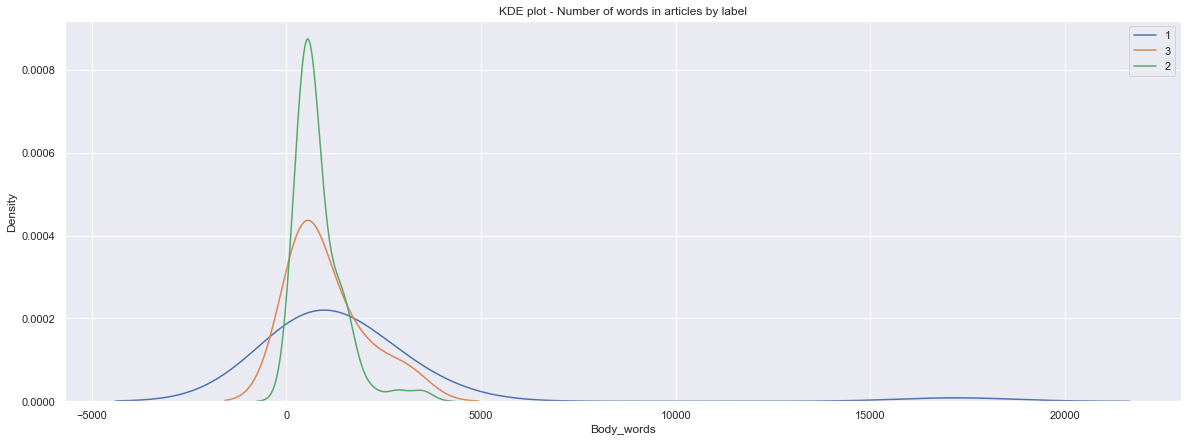

In [742]:
plt.figure(figsize=(20,7))
plt.title('KDE plot - Number of words in articles by label')
for l in train.label.unique():
    sns.kdeplot(train[train.label == l]['Body_words'] ,label=l)
plt.legend()
plt.show()

### Most articles have a similar word count regardless of the class. Classes 2 and 3 are distinguished only by the fact that some articles have more words.

### Let's start transforming the text into understandable forms for classification models. Then we'll learn a few models and see which one is best for the given transformation.

In [751]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RepeatedStratifiedKFold

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from  xgboost import XGBClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight

import fasttext
import fasttext.util
from imblearn.over_sampling import SMOTE, SMOTENC

import itertools

In [746]:
def calculate_metrics(y_test, y_pred):
    f1 = f1_score(y_test, y_pred, average = 'macro')
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average ='macro')
    
    return f1, acc, rec

def run_log_reg(x_train, y_train, x_test, y_test, params, embedding_method):
    logs = []
    
    log_reg = SGDClassifier(**params['SGDClassifier'])
    log_reg2 = LogisticRegression(**params['LogisticRegression'])
    log_reg3 = KNeighborsClassifier()
    log_reg4 = RandomForestClassifier(**params['RandomForestClassifier'])
    log_reg5 = XGBClassifier(**params['XGBClassifier'])
    log_reg6 = SVC(**params['SVC'])
    
    models = [log_reg, log_reg2, log_reg3, log_reg4, log_reg5, log_reg6]
    for model in models:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        y_train_pred = model.predict(x_train)
        f1, acc, rec = calculate_metrics(y_test, y_pred)
        tf1, tacc, trec = calculate_metrics(y_train, y_train_pred)
        logs.append([type(model).__name__, embedding_method, f1, acc, rec, tf1, tacc, trec])

    return logs

In [747]:
#Calculating class weights to prevent overfitting.

class_weight = compute_class_weight(class_weight='balanced', classes = np.unique(train.label), y = train.label)
class_weight = {c:w for c,w in zip(np.unique(train.label), class_weight)}

params = {
    'SGDClassifier':{
        'loss': 'log', 'alpha': 1e-4, 'n_jobs':-1, 'penalty':'l2', 'class_weight': class_weight
    },
    'LogisticRegression':{
        'class_weight' : class_weight, 'C':6
    },
    'RandomForestClassifier':{
        'max_depth' : 4, 'class_weight' : class_weight
    },
    'XGBClassifier':{
        'max_depth' : 4, 'sample_weight' : class_weight
    },
    'SVC':{
        'C' : 6, 'class_weight' : class_weight, 'verbose' : 0
    }
}

In [748]:
#Train, test split

train_data, test_data = train_test_split(train, shuffle = True, test_size=0.2, random_state = 50)
train_data.shape[0], test_data.shape[0]

(80, 20)

In [749]:
#Table with results

results = pd.DataFrame(columns = ['Model', 'Embedding', 'Test f1_score', 'Test accuracy_score', 'Test recall_score', 'Train f1_score', 'Train accuracy_score', 'Train recall_score'])
row = 0

In [750]:
#CountVectorizer embedding
%%time

bow = CountVectorizer()
x_train = bow.fit_transform(train_data['Full text'].values)
x_test = bow.transform(test_data['Full text'].values)
y_train = train_data.label.values
y_test = test_data.label.values

logs = run_log_reg(x_train, y_train, x_test, y_test, params, 'CountVectorizer')

for log in logs:
    results.loc[row] =log
    row+=1

UsageError: Line magic function `%%time` not found.


In [576]:
#Let's check the results
results.sort_values(by='Test f1_score', ascending=False)

Model        Embedding  Test f1_score  \
4           XGBClassifier  CountVectorizer       0.501212   
0           SGDClassifier  CountVectorizer       0.487654   
2    KNeighborsClassifier  CountVectorizer       0.445128   
1      LogisticRegression  CountVectorizer       0.397436   
3  RandomForestClassifier  CountVectorizer       0.371429   
5                     SVC  CountVectorizer       0.343434   

   Test accuracy_score  Test recall_score  Train f1_score  \
4                 0.55           0.504329        1.000000   
0                 0.60           0.517316        0.989761   
2                 0.65           0.463203        0.447222   
1                 0.60           0.415584        1.000000   
3                 0.60           0.398268        0.936522   
5                 0.55           0.367965        0.957681   

   Train accuracy_score  Train recall_score  
4                1.0000            1.000000  
0                0.9875            0.986667  
2                0.6875            0.465000  
1                1.0000            1.000000  
3                0.9250            0.926389  
5                0.9500            0.946667

#### The best model is KNeighborsClassifier with a score of 45% f1, 65% accuracy and 46 recall. XGBClassifier, SGD are overfitted.

#### Let's check how the TfidVectorizer model works

In [577]:
#TfidfVectorizer

tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(train_data['Full text'].values)
x_test = tfidf.transform(test_data['Full text'].values)
y_train = train_data.label.values
y_test = test_data.label.values

logs = logs = run_log_reg(x_train, y_train, x_test, y_test, params, 'TfidfVectorizer')

for log in logs:
    results.loc[row] =log
    row+=1

c:\users\onlyt\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:03:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:03:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [578]:
#Let's check the results
results.sort_values(by='Test f1_score', ascending=False)

Model        Embedding  Test f1_score  \
8     KNeighborsClassifier  TfidfVectorizer       0.677350   
10           XGBClassifier  TfidfVectorizer       0.547009   
4            XGBClassifier  CountVectorizer       0.501212   
0            SGDClassifier  CountVectorizer       0.487654   
2     KNeighborsClassifier  CountVectorizer       0.445128   
6            SGDClassifier  TfidfVectorizer       0.438228   
7       LogisticRegression  TfidfVectorizer       0.438228   
1       LogisticRegression  CountVectorizer       0.397436   
11                     SVC  TfidfVectorizer       0.380247   
3   RandomForestClassifier  CountVectorizer       0.371429   
9   RandomForestClassifier  TfidfVectorizer       0.371429   
5                      SVC  CountVectorizer       0.343434   

    Test accuracy_score  Test recall_score  Train f1_score  \
8                  0.70           0.629870        0.444079   
10                 0.55           0.504329        1.000000   
4                  0.55           0.504329        1.000000   
0                  0.60           0.517316        0.989761   
2                  0.65           0.463203        0.447222   
6                  0.65           0.445887        1.000000   
7                  0.65           0.445887        0.979722   
1                  0.60           0.415584        1.000000   
11                 0.60           0.398268        0.989761   
3                  0.60           0.398268        0.936522   
9                  0.60           0.398268        0.989955   
5                  0.55           0.367965        0.957681   

    Train accuracy_score  Train recall_score  
8                 0.6625            0.470278  
10                1.0000            1.000000  
4                 1.0000            1.000000  
0                 0.9875            0.986667  
2                 0.6875            0.465000  
6                 1.0000            1.000000  
7                 0.9750            0.979722  
1                 1.0000            1.000000  
11                0.9875            0.986667  
3                 0.9250            0.926389  
9                 0.9875            0.993056  
5                 0.9500            0.946667

#### We increased the f1 score by 23%. Best model: KNeighborsClassifier with f1 = 68%, accuracy = 70%, recall = 63%

#### Let's try to use the SMOTE method to balance the data

In [579]:
params = {
    'SGDClassifier':{
        'loss': 'log', 'alpha': 1e-4, 'n_jobs':-1, 'penalty':'l2', 'class_weight': class_weight
    },
    'LogisticRegression':{
        'class_weight' : class_weight, 'C':6
    },
    'RandomForestClassifier':{
         'n_estimators': 100, 'class_weight' : class_weight
    },
    'XGBClassifier':{
        'learning_rate': 0.01, 'n_estimators': 100,  'sample_weight' : class_weight
    },
    'SVC':{
        'C' : 5, 'class_weight' : class_weight, 'verbose' : 0
    }
}

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(x_train, y_train)

logs = logs = run_log_reg(X_res, y_res, x_test, y_test, params, 'TfidfVectorizer with SMOTE ')

for log in logs:
    results.loc[row] =log
    row+=1

c:\users\onlyt\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:03:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:03:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [580]:
#Let's check the results
results.sort_values(by='Test f1_score', ascending=False)

Model                    Embedding  Test f1_score  \
16           XGBClassifier  TfidfVectorizer with SMOTE        0.698485   
8     KNeighborsClassifier              TfidfVectorizer       0.677350   
13      LogisticRegression  TfidfVectorizer with SMOTE        0.666667   
12           SGDClassifier  TfidfVectorizer with SMOTE        0.666667   
10           XGBClassifier              TfidfVectorizer       0.547009   
4            XGBClassifier              CountVectorizer       0.501212   
14    KNeighborsClassifier  TfidfVectorizer with SMOTE        0.495238   
0            SGDClassifier              CountVectorizer       0.487654   
2     KNeighborsClassifier              CountVectorizer       0.445128   
6            SGDClassifier              TfidfVectorizer       0.438228   
7       LogisticRegression              TfidfVectorizer       0.438228   
1       LogisticRegression              CountVectorizer       0.397436   
11                     SVC              TfidfVectorizer       0.380247   
9   RandomForestClassifier              TfidfVectorizer       0.371429   
3   RandomForestClassifier              CountVectorizer       0.371429   
17                     SVC  TfidfVectorizer with SMOTE        0.371429   
5                      SVC              CountVectorizer       0.343434   
15  RandomForestClassifier  TfidfVectorizer with SMOTE        0.341880   

    Test accuracy_score  Test recall_score  Train f1_score  \
16                 0.70           0.748918        1.000000   
8                  0.70           0.629870        0.444079   
13                 0.75           0.660173        0.986111   
12                 0.75           0.660173        1.000000   
10                 0.55           0.504329        1.000000   
4                  0.55           0.504329        1.000000   
14                 0.55           0.538961        0.683761   
0                  0.60           0.517316        0.989761   
2                  0.65           0.463203        0.447222   
6                  0.65           0.445887        1.000000   
7                  0.65           0.445887        0.979722   
1                  0.60           0.415584        1.000000   
11                 0.60           0.398268        0.989761   
9                  0.60           0.398268        0.989955   
3                  0.60           0.398268        0.936522   
17                 0.60           0.398268        0.993055   
5                  0.55           0.367965        0.957681   
15                 0.55           0.367965        1.000000   

    Train accuracy_score  Train recall_score  
16              1.000000            1.000000  
8               0.662500            0.470278  
13              0.986111            0.986111  
12              1.000000            1.000000  
10              1.000000            1.000000  
4               1.000000            1.000000  
14              0.722222            0.722222  
0               0.987500            0.986667  
2               0.687500            0.465000  
6               1.000000            1.000000  
7               0.975000            0.979722  
1               1.000000            1.000000  
11              0.987500            0.986667  
9               0.987500            0.993056  
3               0.925000            0.926389  
17              0.993056            0.993056  
5               0.950000            0.946667  
15              1.000000            1.000000

#### It didn't change anything. XGBClassifier is overfitted.

##### Fasttext embedding. German Model link: https://fasttext.cc/docs/en/crawl-vectors.html

In [752]:
fasttext.util.download_model('de', if_exists='ignore')
ft_model = fasttext.load_model("cc.de.300.bin")

In [581]:
def get_fasttext_embeddings(data):
    embedded = []
    for text in data['Full text']:
        embedded.append(ft_model.get_sentence_vector(text).reshape(1, 300))
    return pd.DataFrame(np.array(embedded).reshape(data.shape[0], 300))

In [582]:
train_data_ft = get_fasttext_embeddings(train_data)
test_data_ft = get_fasttext_embeddings(test_data)

In [583]:
params = {
    'SGDClassifier':{
        'loss': 'log', 'alpha': 1e-4, 'n_jobs':-1, 'penalty':'l2', 'class_weight': class_weight
    },
    'LogisticRegression':{
        'class_weight' : class_weight, 'C':6
    },
    'RandomForestClassifier':{
        'max_depth' : 4, 'class_weight' : class_weight
    },
    'XGBClassifier':{
        'max_depth' : 4, 'sample_weight' : class_weight
    },
    'SVC':{
        'C' : 6, 'class_weight' : class_weight, 'verbose' : 0
    }
}

logs = logs = run_log_reg(train_data_ft, train_data.label, test_data_ft, test_data.label, params, 'Fasttext embedding')

for log in logs:
    results.loc[row] =log
    row+=1

c:\users\onlyt\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:03:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:03:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [584]:
#Let's check the results
results.sort_values(by='Test f1_score', ascending=False)

Model                    Embedding  Test f1_score  \
16           XGBClassifier  TfidfVectorizer with SMOTE        0.698485   
8     KNeighborsClassifier              TfidfVectorizer       0.677350   
12           SGDClassifier  TfidfVectorizer with SMOTE        0.666667   
13      LogisticRegression  TfidfVectorizer with SMOTE        0.666667   
19      LogisticRegression           Fasttext embedding       0.552397   
10           XGBClassifier              TfidfVectorizer       0.547009   
4            XGBClassifier              CountVectorizer       0.501212   
23                     SVC           Fasttext embedding       0.500000   
14    KNeighborsClassifier  TfidfVectorizer with SMOTE        0.495238   
0            SGDClassifier              CountVectorizer       0.487654   
2     KNeighborsClassifier              CountVectorizer       0.445128   
7       LogisticRegression              TfidfVectorizer       0.438228   
6            SGDClassifier              TfidfVectorizer       0.438228   
18           SGDClassifier           Fasttext embedding       0.412698   
1       LogisticRegression              CountVectorizer       0.397436   
21  RandomForestClassifier           Fasttext embedding       0.397436   
11                     SVC              TfidfVectorizer       0.380247   
22           XGBClassifier           Fasttext embedding       0.376068   
9   RandomForestClassifier              TfidfVectorizer       0.371429   
3   RandomForestClassifier              CountVectorizer       0.371429   
17                     SVC  TfidfVectorizer with SMOTE        0.371429   
5                      SVC              CountVectorizer       0.343434   
20    KNeighborsClassifier           Fasttext embedding       0.343434   
15  RandomForestClassifier  TfidfVectorizer with SMOTE        0.341880   

    Test accuracy_score  Test recall_score  Train f1_score  \
16                 0.70           0.748918        1.000000   
8                  0.70           0.629870        0.444079   
12                 0.75           0.660173        1.000000   
13                 0.75           0.660173        0.986111   
19                 0.60           0.551948        0.667008   
10                 0.55           0.504329        1.000000   
4                  0.55           0.504329        1.000000   
23                 0.55           0.504329        0.740022   
14                 0.55           0.538961        0.683761   
0                  0.60           0.517316        0.989761   
2                  0.65           0.463203        0.447222   
7                  0.65           0.445887        0.979722   
6                  0.65           0.445887        1.000000   
18                 0.60           0.432900        0.476917   
1                  0.60           0.415584        1.000000   
21                 0.60           0.415584        1.000000   
11                 0.60           0.398268        0.989761   
22                 0.55           0.385281        1.000000   
9                  0.60           0.398268        0.989955   
3                  0.60           0.398268        0.936522   
17                 0.60           0.398268        0.993055   
5                  0.55           0.367965        0.957681   
20                 0.55           0.367965        0.476780   
15                 0.55           0.367965        1.000000   

    Train accuracy_score  Train recall_score  
16              1.000000            1.000000  
8               0.662500            0.470278  
12              1.000000            1.000000  
13              0.986111            0.986111  
19              0.712500            0.722937  
10              1.000000            1.000000  
4               1.000000            1.000000  
23              0.775000            0.776825  
14              0.722222            0.722222  
0               0.987500            0.986667  
2               0.687500            0.465000  
7               0.975000            0.979722  
6       

### Let's check if SMOTE will help get better results with this method

In [585]:
data_ft = get_fasttext_embeddings(train)
data_ft['label'] = train.label

In [586]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(data_ft.drop(columns=['label']), data_ft['label'])
X_res['label'] = y_res

In [587]:
#Train, test split

train_data_smote, test_data_smote = train_test_split(X_res, shuffle = True, test_size=0.2, random_state = 532)

x_train_smote = train_data_smote.drop(columns=['label'])
x_test_smote = test_data_smote.drop(columns=['label'])
y_train_smote = train_data_smote['label']
y_test_smote = test_data_smote['label']

x_train_smote.shape, x_test_smote.shape

((141, 300), (36, 300))

In [588]:
params = {
    'SGDClassifier':{
        'loss': 'log', 'alpha': 1e-4, 'n_jobs':-1, 'penalty':'l2', 'class_weight': class_weight
    },
    'LogisticRegression':{
        'class_weight' : class_weight, 'C':6
    },
    'RandomForestClassifier':{
         'n_estimators': 100, 'class_weight' : class_weight
    },
    'XGBClassifier':{
        'learning_rate': 0.01, 'n_estimators': 100,  'sample_weight' : class_weight
    },
    'SVC':{
        'C' : 5, 'class_weight' : class_weight, 'verbose' : 0
    }
}

logs = logs = run_log_reg(x_train_smote, y_train_smote, x_test_smote, y_test_smote, params, 'Fasttext embeddings with SMOTE')

for log in logs:
    results.loc[row] =log
    row+=1

c:\users\onlyt\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "sample_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:04:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [589]:
#Let's check the results
results.sort_values(by='Test f1_score', ascending=False)

Model                       Embedding  Test f1_score  \
27  RandomForestClassifier  Fasttext embeddings with SMOTE       0.832168   
28           XGBClassifier  Fasttext embeddings with SMOTE       0.818848   
16           XGBClassifier     TfidfVectorizer with SMOTE        0.698485   
8     KNeighborsClassifier                 TfidfVectorizer       0.677350   
12           SGDClassifier     TfidfVectorizer with SMOTE        0.666667   
13      LogisticRegression     TfidfVectorizer with SMOTE        0.666667   
26    KNeighborsClassifier  Fasttext embeddings with SMOTE       0.650000   
19      LogisticRegression              Fasttext embedding       0.552397   
10           XGBClassifier                 TfidfVectorizer       0.547009   
4            XGBClassifier                 CountVectorizer       0.501212   
23                     SVC              Fasttext embedding       0.500000   
14    KNeighborsClassifier     TfidfVectorizer with SMOTE        0.495238   
24           SGDClassifier  Fasttext embeddings with SMOTE       0.488889   
0            SGDClassifier                 CountVectorizer       0.487654   
2     KNeighborsClassifier                 CountVectorizer       0.445128   
6            SGDClassifier                 TfidfVectorizer       0.438228   
7       LogisticRegression                 TfidfVectorizer       0.438228   
29                     SVC  Fasttext embeddings with SMOTE       0.438218   
18           SGDClassifier              Fasttext embedding       0.412698   
21  RandomForestClassifier              Fasttext embedding       0.397436   
1       LogisticRegression                 CountVectorizer       0.397436   
11                     SVC                 TfidfVectorizer       0.380247   
22           XGBClassifier              Fasttext embedding       0.376068   
17                     SVC     TfidfVectorizer with SMOTE        0.371429   
9   RandomForestClassifier                 TfidfVectorizer       0.371429   
3   RandomForestClassifier                 CountVectorizer       0.371429   
20    KNeighborsClassifier              Fasttext embedding       0.343434   
5                      SVC                 CountVectorizer       0.343434   
15  RandomForestClassifier     TfidfVectorizer with SMOTE        0.341880   
25      LogisticRegression  Fasttext embeddings with SMOTE       0.166667   

    Test accuracy_score  Test recall_score  Train f1_score  \
27             0.833333           0.838095        1.000000   
28             0.833333           0.819048        1.000000   
16             0.700000           0.748918        1.000000   
8              0.700000           0.629870        0.444079   
12             0.750000           0.660173        1.000000   
13             0.750000           0.660173        0.986111   
26             0.666667           0.645238        0.730993   
19             0.600000           0.551948        0.667008   
10             0.550000           0.504329        1.000000   
4              0.550000           0.504329        1.000000   
23             0.550000           0.504329        0.740022   
14             0.550000           0.538961        0.683761   
24             0.555556           0.513492        0.491304   
0              0.600000           0.517316        0.989761   
2              0.650000           0.463203        0.447222   
6              0.650000           0.445887        1.000000   
7              0.650000           0.445887        0.979722   
29             0.555556           0.515873        0.525740   
18             0.600000           0.432900        0.476917   
21             0.600000           0.415584        1.000000   
1              0.600000           0.415584        1.000000   
11             0.600000           0.398268        0.989761   
22             0.550000           0.385281        1.000000   
17             0.600000           0.398268        0.993055   
9              0.600000           0.398268        0.989955   
3              0.6000

#### The best model might seem to be the Random Forest, but it is overfitted. The best model is KNeighborsClassifier with Fasttext embeddings and SMOTE. 65% f1, 66% accuracy and 65% recall. This model is the most stable. I will try to limit the RandomForest model to prevent overfitting

In [655]:
rf = RandomForestClassifier(class_weight = class_weight, n_estimators=80, max_depth=5, ccp_alpha = 0.0182, random_state = 123)

rf.fit(x_train_smote, y_train_smote)
y_pred = rf.predict(x_test_smote)
train_pred = rf.predict(x_train_smote)

train_score = calculate_metrics(y_train_smote, train_pred)
test_score  = calculate_metrics(y_test_smote, y_pred)

print(f'Score on train data: f1: {train_score[0]}, Accuracy: {train_score[1]} Recall: {train_score[2]}')
print(f'Score on test data: f1: {test_score[0]}, Accuracy: {test_score[1]} Recall: {test_score[2]}')

Score on train data: f1: 0.9645349933974722, Accuracy: 0.9645390070921985 Recall: 0.9659863945578232
Score on test data: f1: 0.8907407407407407, Accuracy: 0.8888888888888888 Recall: 0.8817460317460317


#### It is much better, we have about 89% of all metrics on the test set and 96% on the training set. It is still an overfitted model. let's check KNN model

In [639]:
knn_k = np.arange(1,15)

for k in knn_k:
    print(f'K = {k}')
    rf = KNeighborsClassifier(n_neighbors=k)#6
    rf.fit(x_train_smote, y_train_smote)
    y_pred = rf.predict(x_test_smote)
    train_pred = rf.predict(x_train_smote)

    train_score = calculate_metrics(y_train_smote, train_pred)
    test_score  = calculate_metrics(y_test_smote, y_pred)

    print(f'Score on train data: f1: {train_score[0]}, Accuracy: {train_score[1]} Recall: {train_score[2]}')
    print(f'Score on test data: f1: {test_score[0]}, Accuracy: {test_score[1]} Recall: {test_score[2]}')
    print('\n')

K = 1
Score on train data: f1: 1.0, Accuracy: 1.0 Recall: 1.0
Score on test data: f1: 0.8285714285714286, Accuracy: 0.8333333333333334 Recall: 0.8285714285714286


K = 2
Score on train data: f1: 0.8932411674347157, Accuracy: 0.8936170212765957 Recall: 0.8976697061803445
Score on test data: f1: 0.7284427284427285, Accuracy: 0.75 Recall: 0.7166666666666667


K = 3
Score on train data: f1: 0.8044867645838519, Accuracy: 0.8156028368794326 Recall: 0.8216304015696113
Score on test data: f1: 0.6085434173669467, Accuracy: 0.6388888888888888 Recall: 0.6119047619047618


K = 4
Score on train data: f1: 0.7581545740113516, Accuracy: 0.7801418439716312 Recall: 0.7882214824464064
Score on test data: f1: 0.6324175824175824, Accuracy: 0.6666666666666666 Recall: 0.6357142857142857


K = 5
Score on train data: f1: 0.7309925371353373, Accuracy: 0.75177304964539 Recall: 0.7585918528167768
Score on test data: f1: 0.65, Accuracy: 0.6666666666666666 Recall: 0.6452380952380953


K = 6
Score on train data: f1:

#### The best model is for k = 6 with f1 = 71%, Accuracy = 72% and Recall = 70%. It is the best because the results on the training set are the closest to the results on the test, which makes it the most balanced. Although the accuracy is about 16% lower than that of RandomForest, I will choose this model for target grain prediction.

In [658]:
rf = KNeighborsClassifier(n_neighbors=6)
rf.fit(x_train_smote, y_train_smote)

KNeighborsClassifier(n_neighbors=6)

In [659]:
import joblib

In [660]:
joblib.dump(rf, 'tumorboard_model.pkl')

['tumorboard_model.pkl']

In [661]:
cm = confusion_matrix(y_test_smote, y_pred)

plt.title('Confusion Matrix')
sns.set(font_scale=1.0) #for label size
sns.heatmap(cm, annot = True, fmt = 'd', annot_kws={"size": 14}, cmap = 'Blues')# font size

plt.xlabel('Truth')
plt.ylabel('Prediction')

Text(30.5, 0.5, 'Prediction')

#### The confusion matrix shows that the model is very good.

### Test csv

In [662]:
test = pd.read_csv('test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     48 non-null     object
 1   doc_id  48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 896.0+ bytes


In [663]:
test = pd.merge(test, df, on = 'doc_id')
test.shape

(48, 12)

In [664]:
testdata_ft = get_fasttext_embeddings(test)

In [665]:
test_predictions = rf.predict(testdata_ft)

In [666]:
test['prediction'] = test_predictions

In [667]:
test[['doc_id', 'prediction']].to_csv('submission.csv')

In [668]:
np.mean([np.max(x) for x in rf.predict_proba(testdata_ft)])

0.6875

#### The model had an average of 70% confidence in classifying new articles.

## Tumor Type

In [709]:
keyword2tumor = pd.read_csv('keyword2tumor_type.csv')

tumordict = dict(keyword2tumor.values)
df['Tumor type'] = None

for index, row in df.iterrows():
    for k,v in tumordict.items():
        if k in row['Full text']:
            df.loc[index, 'Tumor type'] = v
df['Tumor type'] = df['Tumor type'].fillna('Unknown')

In [710]:
df['Tumor type'].value_counts().plot(kind='barh')

<AxesSubplot:>